In [17]:
import time
import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data as utils
import torch.nn.init as init
from torch.autograd import Variable

In [18]:
mode = 'ROC'

In [19]:
f_rnd = pd.read_hdf("/data/t3home000/spark/LHCOlympics_previous/LHC-Olympics/Code/Nsubjettiness_mjj.h5")

In [20]:
f_rnd.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15'],
      dtype='object')

In [21]:
f_rnd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,98.677270,0.528903,0.788281,0.904471,4.241889,136.0,1285.895950,53.519023,0.668562,0.735745,0.755674,1.895988,128.0,1282.286017,2577.571899,0.0
1,584.595432,0.345626,0.463461,0.865982,1.069972,320.0,1334.493332,405.034096,0.264362,0.793461,0.830032,1.377217,348.0,1306.137883,3807.507389,0.0
2,159.597526,0.677692,0.690707,0.695322,1.310040,332.0,678.557182,113.768840,0.713481,0.922610,0.782783,1.887494,236.0,1072.462085,1710.965414,0.0
3,515.237299,0.091038,0.784454,0.860716,1.102743,248.0,1284.020224,161.648798,0.727507,0.719564,0.870109,1.997360,352.0,1217.031950,2603.379037,0.0
4,142.420213,0.507714,0.522686,0.904070,1.853319,220.0,1087.658980,105.721163,0.344534,0.614579,0.863765,1.113248,204.0,1205.343324,3294.162200,1.0


In [22]:
if mode == 'ROC':
    dt = f_rnd.values
else:
    dt_PureBkg = f_PureBkg.values

In [23]:
index_list = [0,1,2,3,4,5,7,8,9,10,11,12]
for i in index_list:
    dt[:,i] = (dt[:,i]-np.mean(dt[:,i]))/np.std(dt[:,i])

In [24]:
dt

array([[-9.76387849e-01,  1.92399512e-01,  6.41817483e-01, ...,
         1.28228602e+03,  2.57757190e+03,  0.00000000e+00],
       [ 2.56368470e+00, -7.40919608e-01, -1.86301047e+00, ...,
         1.30613788e+03,  3.80750739e+03,  0.00000000e+00],
       [-5.32563884e-01,  9.50088429e-01, -1.10614099e-01, ...,
         1.07246208e+03,  1.71096541e+03,  0.00000000e+00],
       ...,
       [-1.14348172e+00,  7.85252036e-01,  1.12078063e-01, ...,
         1.41629773e+03,  3.23296780e+03,  0.00000000e+00],
       [-7.63183147e-01, -5.63390513e-02, -6.01315795e-01, ...,
         1.13146135e+03,  3.60117240e+03,  0.00000000e+00],
       [-1.02491235e+00, -1.27034111e-01, -8.10810555e-01, ...,
         1.07347082e+03,  2.49024909e+03,  0.00000000e+00]])

In [25]:
idx = dt[:,15]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]

In [26]:
print(bkg_idx)

[      0       1       2 ... 1099997 1099998 1099999]


In [27]:
dt[bkg_idx].shape

(1000000, 16)

In [28]:
total_PureBkg = torch.tensor(dt[bkg_idx])
total_PureBkg_train_x_1 = total_PureBkg.t()[0:6].t()
total_PureBkg_train_x_3 = total_PureBkg.t()[7:13].t()
total_PureBkg_selection = torch.cat((total_PureBkg_train_x_1,total_PureBkg_train_x_3),dim=1)

In [29]:
total_PureBkg_selection.shape

torch.Size([1000000, 12])

In [30]:
train_set, val_set = torch.utils.data.random_split(total_PureBkg_selection, [800000, 200000])

In [31]:
len(train_set)

800000

In [32]:
bs = 256
bkgAE_train_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs, shuffle=True)
bkgAE_test_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs)

In [33]:
class Encoder(nn.Module):
    ''' This the encoder part of VAE

    '''
    def __init__(self, z_dim):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            z_dim: A integer indicating the latent dimension.
        '''
        super().__init__()

        self.linear1 = nn.Linear(12, 48)
        self.linear2 = nn.Linear(48, 30)
        self.linear3 = nn.Linear(30, 20)
        self.linear4 = nn.Linear(20, 10)
        self.linear5 = nn.Linear(10, 6)
        hidden_dim = 6
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim]
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        x = F.leaky_relu(self.linear3(x))
        x = F.leaky_relu(self.linear4(x))
        x = F.leaky_relu(self.linear5(x))

        #hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]
        
        z_mu = self.mu(x)
        # z_mu is of shape [batch_size, latent_dim]
        z_var = self.var(x)
        # z_var is of shape [batch_size, latent_dim]

        return z_mu, z_var


In [34]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE

    '''
    def __init__(self, z_dim):
        '''
        Args:
            z_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the output dimension (in case of MNIST it is 28 * 28)
        '''
        super().__init__()

        self.linear1 = nn.Linear(z_dim, 6)
        self.linear2 = nn.Linear(6, 10)
        self.linear3 = nn.Linear(10, 20)
        self.linear4 = nn.Linear(20, 30)
        self.linear5 = nn.Linear(30, 48)
        self.out = nn.Linear(48, 12)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim]
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        x = F.leaky_relu(self.linear3(x))
        x = F.leaky_relu(self.linear4(x))
        x = F.leaky_relu(self.linear5(x))

        #hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]

        predicted = torch.sigmoid(self.out(x))
        # predicted is of shape [batch_size, output_dim]

        return predicted


In [35]:
class VAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.

    '''
    def __init__(self, enc, dec):
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encode
        z_mu, z_var = self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        # decode
        predicted = self.dec(x_sample)
        return predicted, z_mu, z_var


In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda:0


'GeForce RTX 2080 Ti'

In [42]:
# encoder
encoder = Encoder(1)

# decoder
decoder = Decoder(1)

# vae
model = VAE(encoder, decoder).to(device)

# optimizer
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)

In [43]:
print(encoder)
print(device)

Encoder(
  (linear1): Linear(in_features=12, out_features=48, bias=True)
  (linear2): Linear(in_features=48, out_features=30, bias=True)
  (linear3): Linear(in_features=30, out_features=20, bias=True)
  (linear4): Linear(in_features=20, out_features=10, bias=True)
  (linear5): Linear(in_features=10, out_features=6, bias=True)
  (mu): Linear(in_features=6, out_features=1, bias=True)
  (var): Linear(in_features=6, out_features=1, bias=True)
)
cuda:0


In [44]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, x in enumerate(bkgAE_train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.float().cuda()

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, z_mu, z_var = model(x)

        # reconstruction loss
        recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

        # kl divergence loss
        kl_loss = torch.sum(z_mu**2+z_var**2)

        # total loss
        #loss = recon_loss + kl_loss
        loss = kl_loss

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss


In [45]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, x in enumerate(bkgAE_test_iterator):
            # reshape the data
            #x = x.view(-1, 28 * 28)
            x = x.float().cuda()
            # forward pass
            x_sample, z_mu, z_var = model(x)

            # reconstruction loss
            recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

            # kl divergence loss
            kl_loss = torch.sum(z_mu**2+z_var**2)

            # total loss
            # loss = recon_loss + kl_loss
            loss = kl_loss
            test_loss += loss.item()

    return test_loss

In [46]:
best_test_loss = float('inf')

for e in range(100):

    train_loss = train()
    test_loss = test()

    train_loss /= len(total_PureBkg_selection)
    test_loss /= len(total_PureBkg_selection)

    print(f'Epoch {e}, Train Loss: {train_loss:.10f}, Test Loss: {test_loss:.10f}')

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
        print("Saving model!")
        if mode == 'ROC':
            torch.save(model.state_dict(),"/data/t3home000/spark/QUASAR/weights/bkg_vae_Vanilla_ONLYKL_MetricEmbed_RND.h5")
        else:
            torch.save(model.state_dict(), "/data/t3home000/spark/QUASAR/weights/bkg_vae_Vanilla_ONLYKL_MetricEmbed_PureBkg.h5")
    else:
        patience_counter += 1
        print("Not saving model!")

    if patience_counter > 3:
        print("Patience Limit Reached")
        break

Epoch 0, Train Loss: 0.1175096342, Test Loss: 0.0381755509
Saving model!
Epoch 1, Train Loss: 0.0196791248, Test Loss: 0.0047025801
Saving model!
Epoch 2, Train Loss: 0.0010514616, Test Loss: 0.0001899120
Saving model!
Epoch 3, Train Loss: 0.0000675048, Test Loss: 0.0000108800
Saving model!
Epoch 4, Train Loss: 0.0000042370, Test Loss: 0.0000015120
Saving model!
Epoch 5, Train Loss: 0.0000007988, Test Loss: 0.0000003641
Saving model!
Epoch 6, Train Loss: 0.0000002020, Test Loss: 0.0000000947
Saving model!
Epoch 7, Train Loss: 0.0000000515, Test Loss: 0.0000000225
Saving model!
Epoch 8, Train Loss: 0.0000000114, Test Loss: 0.0000000056
Saving model!
Epoch 9, Train Loss: 0.0000000019, Test Loss: 0.0000000012
Saving model!
Epoch 10, Train Loss: 0.0000000003, Test Loss: 0.0000000002
Saving model!
Epoch 11, Train Loss: 0.0000000001, Test Loss: 0.0000000001
Saving model!
Epoch 12, Train Loss: 0.0000000001, Test Loss: 0.0000000001
Not saving model!
Epoch 13, Train Loss: 0.0000000001, Test Los

KeyboardInterrupt: 

In [ ]:
print(mode)

In [47]:
model.load_state_dict(torch.load("/data/t3home000/spark/QUASAR/weights/bkg_vae_Vanilla_ONLYKL_MetricEmbed_RND.h5"))

<All keys matched successfully>

In [ ]:
def get_loss(dt, index_list):
    print(dt.shape)
    
    #for i in index_list:
    #    print(i)
    #    dt[:,i] = (dt[:,i]-np.mean(dt[:,i]))/np.std(dt[:,i])
  
    
    total_in = torch.tensor(dt)
    total_in_train_x_1 = total_in.t()[0:6].t()
    total_in_train_x_3 = total_in.t()[7:13].t()
    total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_3),dim=1)
    z_mu, z_var  = model.enc(total_in_selection.float().cuda())
    std = torch.exp(z_var / 2)
    eps = torch.randn_like(std)
    x_sample = eps.mul(std).add_(z_mu)
    decoded_bkg = model.dec(x_sample)
    loss_bkg = torch.mean((decoded_bkg-total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()


    
    #with torch.no_grad():
        # reconstruction loss
        #x_sample, z_mu, z_var = model(total_in_selection.float().cuda())
        #recon_loss = F.binary_cross_entropy(x_sample, total_in_selection.float().cuda(), size_average=False, reduce=None)
        

        # kl divergence loss
        #kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        # total loss
        #loss = recon_loss + kl_loss
        #loss = torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    return loss_bkg

In [48]:
data_bkg = torch.tensor(dt[bkg_idx])
data_signal = torch.tensor(dt[signal_idx])

In [49]:
data_bkg.shape

torch.Size([1000000, 16])

In [50]:
data_train_x_1 = data_bkg.t()[0:6].t()
data_train_x_2 = data_bkg.t()[7:13].t()
data_test_bkg = torch.cat((data_train_x_1,data_train_x_2),dim=1)

In [51]:
data_train_x_1 = data_signal.t()[0:6].t()
data_train_x_2 = data_signal.t()[7:13].t()
data_test_signal = torch.cat((data_train_x_1,data_train_x_2),dim=1)

In [52]:
z_mu, z_var  = model.enc(data_test_bkg.float().cuda())

In [67]:
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 10})

In [55]:
std = torch.exp(z_var / 2)
eps = torch.randn_like(std)
x_sample = eps.mul(std).add_(z_mu)

In [56]:
z_mu_arr = z_mu.data.cpu().numpy()

std_arr = std.data.cpu().numpy()

Text(0.5, 0, 'z_mu')

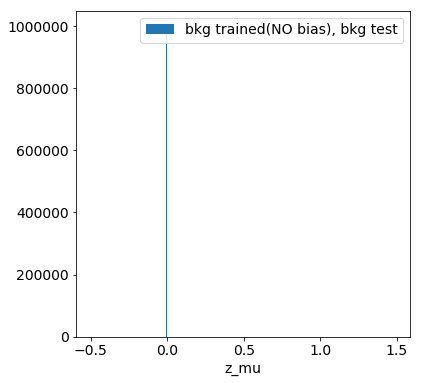

In [60]:
plt.hist(z_mu_arr, bins=np.arange(-0.5,1.5,0.01),color='C0',label='bkg trained(NO bias), bkg test');
plt.legend()
plt.xlabel('z_mu')

In [ ]:
plt.hist(std_arr, bins=np.arange(-0.5,1.5,0.01),label='bkg trained(NO bias), bkg test');
plt.legend()

plt.xlabel('z_std')

In [ ]:
decoded_bkg = model.dec(x_sample)

In [ ]:
loss_bkg = torch.mean((decoded_bkg-data_test_bkg.float().cuda())**2,dim=1).data.cpu().numpy()


In [57]:
z_mu2, z_var2  = model.enc(data_test_signal.float().cuda())

In [58]:
std2 = torch.exp(z_var2 / 2)
eps2 = torch.randn_like(std2)
x_sample2 = eps2.mul(std2).add_(z_mu2)

In [59]:
z_mu_arr2 = z_mu2.data.cpu().numpy()

std_arr2 = std2.data.cpu().numpy()

Text(0.5, 0, 'z_mu')

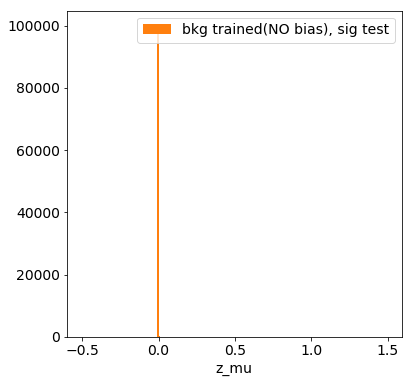

In [61]:
plt.hist(z_mu_arr2, bins=np.arange(-0.5,1.5,0.01),color='C1',label='bkg trained(NO bias), sig test');
plt.legend()
plt.xlabel('z_mu')

In [ ]:
plt.hist(std_arr2, bins=np.arange(-0.5,1.5,0.01),color='C1',label='bkg trained(No bias), sig test');
plt.legend()
plt.xlabel('z_std')

Text(0.5, 0, 'loss')

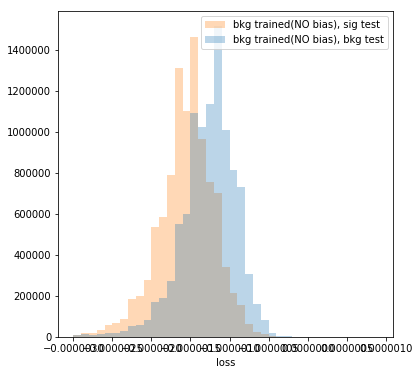

In [69]:
plt.hist(z_mu_arr2, bins=np.arange(-3e-6,1e-6,1e-7),color='C1',label='bkg trained(NO bias), sig test',alpha=0.3,density=True);
plt.hist(z_mu_arr, bins=np.arange(-3e-6,1e-6,1e-7),color='C0',label='bkg trained(NO bias), bkg test',alpha=0.3,density=True);

plt.legend()
plt.xlabel('loss')

In [ ]:
decoded_sig = model.dec(x_sample2)

In [ ]:
loss_sig = torch.mean((decoded_sig-data_test_signal.float().cuda())**2,dim=1).data.cpu().numpy()


In [ ]:
loss_bkg

In [ ]:
loss_sig

In [ ]:
bins = np.linspace(0,5,100)
plt.hist(loss_bkg,bins=bins,alpha=0.3,color='b',label='bkg')
plt.hist(loss_sig,bins=bins,alpha=0.3,color='r',label='sig')

In [ ]:
f = pd.read_hdf("/data/t3home000/spark/LHCOlympics_previous/LHC-Olympics/Code/Nsubjettiness_mjj.h5")
dt = f.values

In [ ]:
dt.shape

In [ ]:
idx = dt[:,15]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]

In [ ]:
loss_bkg = get_loss(dt[bkg_idx],[0,1,2,3,4,5,7,8,9,10,11,12])
loss_sig = get_loss(dt[signal_idx],[0,1,2,3,4,5,7,8,9,10,11,12])

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,5,100)
plt.hist(loss_bkg,bins=bins,alpha=0.3,color='b',label='bkg')
plt.hist(loss_sig,bins=bins,alpha=0.3,color='r',label='sig')
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

### ROC


In [ ]:
def get_tpr_fpr(sigloss,bkgloss,aetype='bkg'):
    bins = np.linspace(0,50,1001)
    tpr = []
    fpr = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    return tpr,fpr  

### PRECISION - RECALL

In [ ]:
def get_precision_recall(sigloss,bkgloss,aetype='bkg'):
    bins = np.linspace(0,100,1001)
    tpr = []
    fpr = []
    precision = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss<cut)[0].shape[0])/(np.where(bkgloss<cut)[0].shape[0]+np.where(sigloss<cut)[0].shape[0]))
            
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss>cut)[0].shape[0])/(np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]))
    return precision,tpr      